In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

from time import time

import utils

In [2]:
# Parameters
device = 'cpu' #to do
k_curve = 100.

mpc_T = 30
H_curve = 30

n_batch = 32

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 0.60

dt = 0.04

# not using
ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

track_density = 300
track_width = 0.5


params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max, k_curve])


# Let's try to create a track 
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [3]:
true_sim_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params, device)

model = utils.NN(H_curve, 3, 8, mpc_T)
model.load_state_dict(torch.load(f'./models/model_{mpc_T}_{H_curve}_60.pkl'))

N_test = 1
mpc_T_test = mpc_T

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(5.31)
d = torch.tensor(0.00)
d_pen = utils.penalty_d(d, 0.35*track_width)
r = torch.tensor(0.0)
v_x = torch.tensor(0.5) #make sure this is never 0
v_ub = utils.penalty_v(v_x, v_max*0.95)
v_y = torch.tensor(0.0)  # this can be zero
sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_exec_sim = torch.tensor([sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub])

mpc_T_test = mpc_T

control = casadi_control.CasadiControl(track_coord, params.numpy(), k_curve)

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = 4 + 2 + 2 #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = 2 #number control inputs

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

8
9


In [4]:
N_sim_total = 100
#x_simulated = torch.zeros((N_sim_total,1,10))

#x_simulated[0] = x_init_test[0]

x_execution = np.zeros((N_sim_total,1,8))
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()

x_simulated[0,0,5] = 0.

#q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
#p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

q_penalty_batch = q_penalty.unsqueeze(0).repeat(mpc_T,1).unsqueeze(1).repeat(1,N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(mpc_T,1).unsqueeze(1).repeat(1,N_test,1)

u_exec = np.zeros((N_sim_total, 2))

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.round(3))

    Q_test_batch, p_test_batch = utils.inference_params(
        torch.tensor(x_sim).float().detach(), track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    print(test_q)
    print(test_p)
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    #test_q=np.array([0.,1.5,0.2,0.01,0.0,0.,0.,0.0,0.,0.,0.1,0.1])
    #test_p=np.array([0.,0.,0.,0.,-1.,0.,0.,-4.5,100.,100., 0., 0.])

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim,
        mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:].reshape(mpc_T_test,du).copy()
    x_mpc_test = sol[:-du*mpc_T_test].reshape(mpc_T_test+1,dx-dc-df).copy()

    x_sim = true_sim_dx.forward(torch.tensor(x_sim[0]), torch.tensor(u_mpc_test[0])).numpy()
        
    u_exec[i] = u_mpc_test[0].copy()

    x_simulated[i,0,:4] = torch.tensor(x_sim[0,:4])
    x_simulated[i,0,4] = torch.tensor(x_sim[0,0])
    x_sim[0,4] = 0.
    x_simulated[i,0,5] = 0.
    

    #x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    #x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    #x_simulated[i,0,5] = 0.

It: 1 x= [[ 5.31  0.   -0.    0.5   5.31  0.    0.    0.  ]]
[9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06
 9.9999997e-06 9.9999997e-05 9.9999997e-05 8.5618608e-02 2.5896681e-02]
[ 0.         -0.07482399  0.00800761 -0.3234651   0.         -0.2687852
  1.          1.         -0.36086538 -0.08744805]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

It: 2 x= [[5.329e+00 5.000e-03 6.200e-02 6.200e-01 5.329e+00 0.000e+00 0.000e+00
  0.000e+00]]
[1.000000e-05 1.000000e-05 1.000000e-05 1.000000e-05 1.000000e-05
 1.000000e-05 1.000000e-04 1.000000e-04 1.000000e-05 3.177322e-02]
[ 0.          0.00532486  0.01042488 -0.08127724  0.       

It: 25 x= [[6.437 0.068 0.456 1.608 6.437 0.    0.    0.   ]]
[1.000000e-05 1.000000e-05 1.000000e-05 1.000000e-05 1.000000e-05
 1.000000e-05 1.000000e-04 1.000000e-04 1.000000e-05 3.767188e-02]
[ 0.         -0.01799497 -0.00520942 -0.13234033  0.         -0.14103699
  1.          1.         -0.12574723 -0.06359036]
It: 26 x= [[6.501 0.077 0.353 1.616 6.501 0.    0.    0.   ]]
[9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06
 9.9999997e-06 9.9999997e-05 9.9999997e-05 9.9999997e-06 3.6773067e-02]
[ 0.0000000e+00 -2.2981636e-02 -8.8074803e-04 -1.3058282e-01
  0.0000000e+00 -1.3889940e-01  1.0000000e+00  1.0000000e+00
 -1.2282689e-01 -6.3049182e-02]
It: 27 x= [[6.565 0.088 0.295 1.736 6.565 0.    0.    0.   ]]
[9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06 9.9999997e-06
 9.9999997e-06 9.9999997e-05 9.9999997e-05 9.9999997e-06 3.6738187e-02]
[ 0.0000000e+00 -3.0255388e-02  1.9537099e-04 -1.3580109e-01
  0.0000000e+00 -1.4716920e-01  1.0000000e+00  1.0000000e

CasADi - 2024-06-25 00:46:11 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


SystemError: <built-in function Function_call> returned a result with an error set

In [8]:
p_test_batch[:,0,3]

tensor([-0.0700, -0.1011,  0.0038, -0.1521, -0.0550, -0.1471, -0.0962, -0.1740,
        -0.0911, -0.1363, -0.0281, -0.1767, -0.0340, -0.1291, -0.0395, -0.1616,
        -0.1178, -0.1301, -0.1534, -0.1058, -0.1320, -0.1082, -0.1039, -0.1568,
        -0.0489, -0.1007, -0.1252, -0.1162, -0.0572, -0.0657],
       grad_fn=<SelectBackward0>)

In [6]:
test_q

array([1.e-05, 1.e-01, 1.e-01, 1.e-05, 1.e-05, 1.e-05, 1.e-04, 1.e-04,
       1.e-05, 1.e-05], dtype=float32)

In [7]:
test_p

array([ 0.        ,  0.02904348,  0.0328856 , -0.07003783,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ],
      dtype=float32)

In [8]:
x_sim_try = x_sim.copy()

In [73]:
x_sim_try[0,0] = 7.53

In [6]:
sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim,
        mpc_T_test,df,dc,dx,du)

In [7]:
sol[-du*mpc_T_test:].reshape(-1,2)

array([[-6.70651190e-11,  6.00000034e-01],
       [-3.05244519e-11,  6.00000034e-01],
       [-8.93854048e-12,  6.00000034e-01],
       [-8.65241457e-12,  6.00000034e-01],
       [-8.28603017e-12,  6.00000034e-01],
       [-7.86787289e-12,  6.00000034e-01],
       [-7.37603176e-12,  6.00000034e-01],
       [-6.77998331e-12,  6.00000034e-01],
       [-2.29420214e-13,  6.00000034e-01],
       [ 3.85943542e-01,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.00000003e+00,  6.00000034e-01],
       [ 3.

In [11]:
sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim_try,
        mpc_T_test,df,dc,dx,du)

In [9]:
sol[-du*mpc_T_test:]

array([ 9.75005266e-08,  1.78436812e-01,  3.00000003e+00,  1.78454354e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01,
        3.00000003e+00, -6.00000034e-01,  3.00000003e+00, -6.00000034e-01])

In [8]:
sol[:-du*mpc_T_test].reshape(-1,4)

array([[ 7.23796365e+00,  7.42405929e-02, -7.99919684e-01,
        -1.00000010e-01],
       [ 7.23439772e+00,  7.60533087e-02, -8.06389475e-01,
        -1.00000010e-01],
       [ 7.23084349e+00,  7.78890556e-02, -8.12857851e-01,
        -1.00000010e-01],
       [ 7.22730103e+00,  7.97477518e-02, -8.19324222e-01,
        -1.00000010e-01],
       [ 7.22377043e+00,  8.16293123e-02, -8.25787753e-01,
        -1.00000010e-01],
       [ 7.22025172e+00,  8.35336486e-02, -8.32247270e-01,
        -1.00000010e-01],
       [ 7.21674489e+00,  8.54606670e-02, -8.38701121e-01,
        -1.00000010e-01],
       [ 7.21324984e+00,  8.74102673e-02, -8.45146985e-01,
        -1.00000010e-01],
       [ 7.20976640e+00,  8.93823406e-02, -8.51581607e-01,
        -1.00000010e-01],
       [ 7.20629423e+00,  9.13767658e-02, -8.58000433e-01,
        -1.00000010e-01],
       [ 7.20283280e+00,  9.33934058e-02, -8.64397102e-01,
        -8.45622685e-02],
       [ 7.19991413e+00,  9.51173729e-02, -8.69780039e-01,
      

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


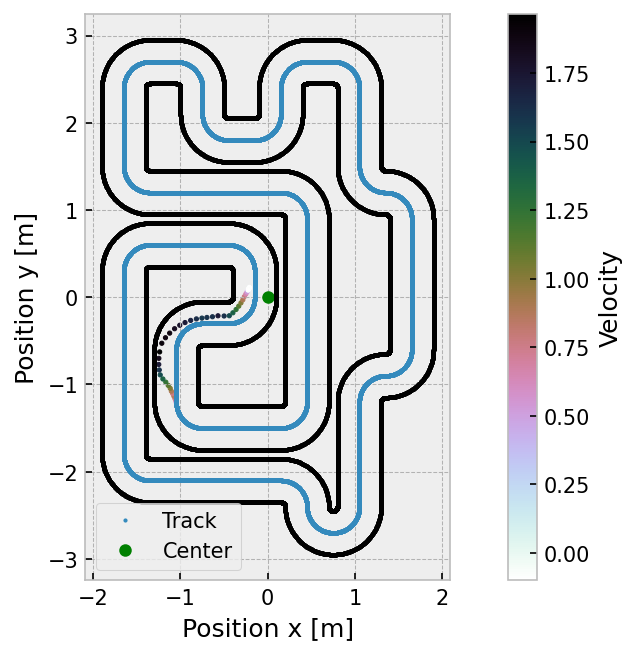

In [5]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = utils.frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3], cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


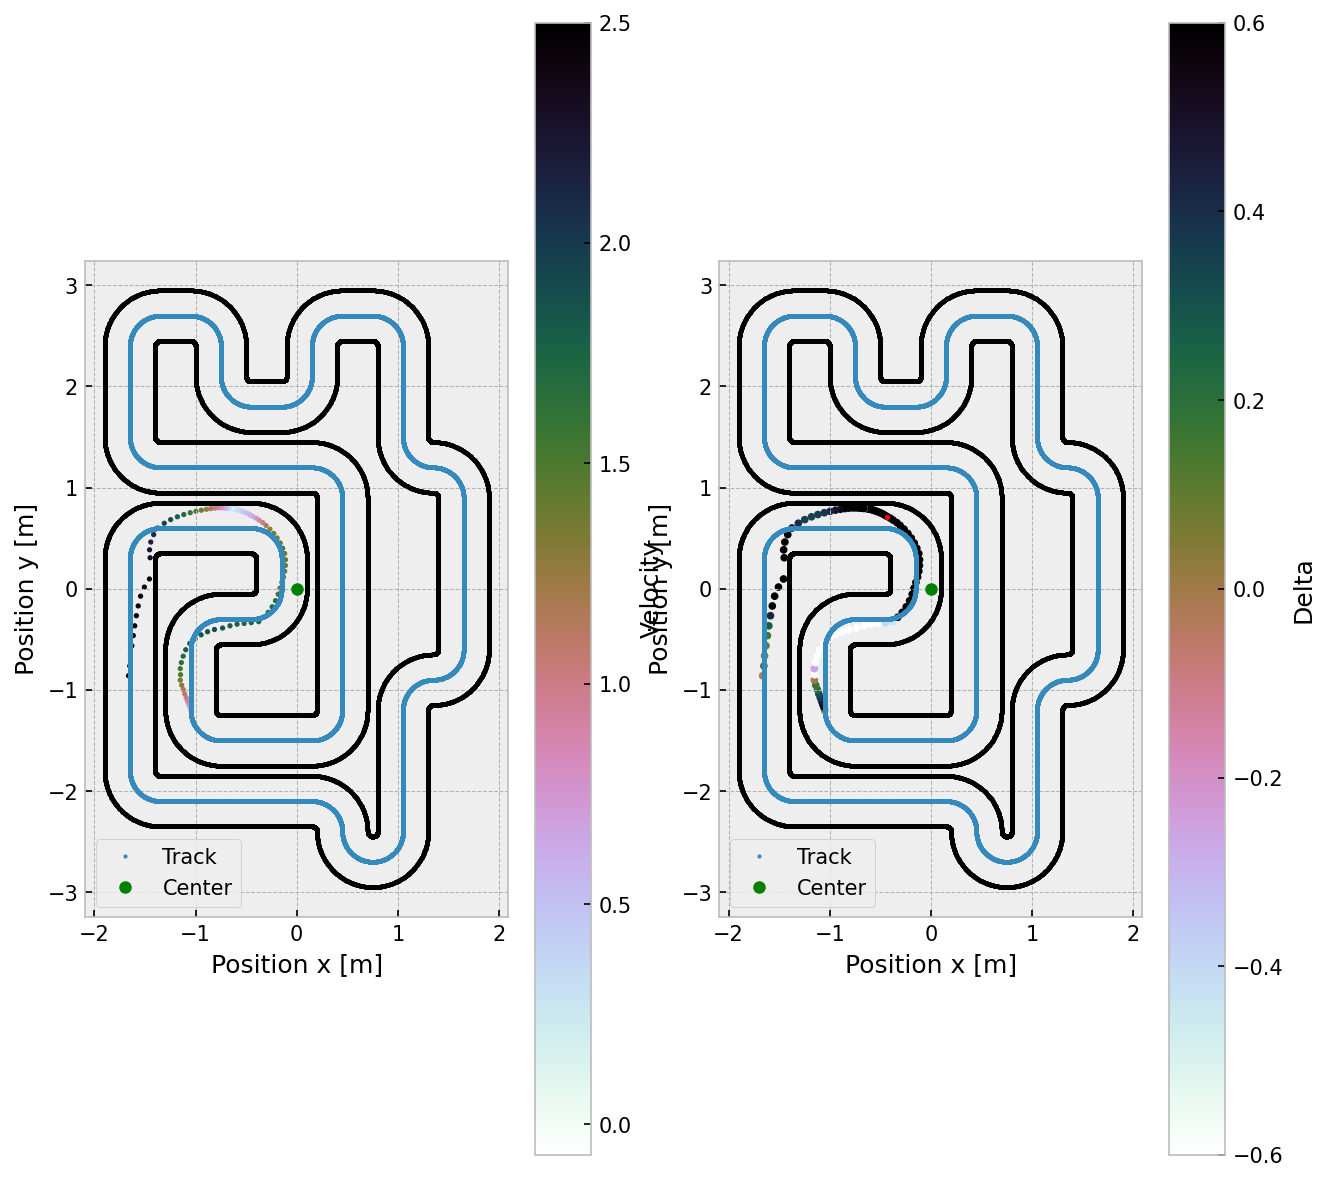

In [6]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = utils.frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm

fig, axs = plt.subplots(1,2, figsize=(10,10), dpi=150)
gen.plotPoints(axs[0])
custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = axs[0].scatter(x_plot, y_plot, c=x_simulated[:,0,3], cmap=custom_cmap, s=4)
cbar1 = plt.colorbar(sct)
cbar1.set_label('Velocity') 

gen.plotPoints(axs[1])
custom_cmap2 = plt.get_cmap('cubehelix').reversed()
sct2 = axs[1].scatter(x_plot, y_plot, c=u_exec[:,1], cmap=custom_cmap2, s=10)
cbar2 = plt.colorbar(sct2)
cbar2.set_label('Delta') 

axs[1].scatter(x_plot[47], y_plot[47], c='red', s=4)

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()